<a href="https://colab.research.google.com/github/wonyoung-ji/NLP/blob/master/7%EC%9D%BC%EC%B0%A8/%EA%B0%90%EC%A0%95%EB%B6%84%EC%84%9D_%EB%84%A4%EC%9D%B4%EB%B2%84%EC%98%81%ED%99%94%EB%A6%AC%EB%B7%B0DL_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사용할 패키지 설치

In [2]:
 %matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
! sudo apt-get install g++ openjdk-7-jdk #Install Java 1.7+ 
#!sudo apt-get install python-dev; pip install konlpy # Python 2.x 
!sudo apt-get install python3-dev; pip3 install konlpy # Python 3.x 
!sudo apt-get install curl 
! bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [40]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [11]:
from konlpy.tag import Mecab
mecab = Mecab()

# 데이터 불러오기

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [188]:
train = pd.DataFrame(pd.read_csv('/content/gdrive/My Drive/NLP/네이버영화리뷰실습/ratings_train.txt', sep='\t', quoting=3,encoding='utf-8')) 
train.dropna(inplace=True)
train.reset_index(inplace=True)
train.head()

,index,id,document,label
0,0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,2,10265843,너무재밓었다그래서보는것을추천한다,0
3,3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [189]:
test = pd.DataFrame(pd.read_csv('/content/gdrive/My Drive/NLP/네이버영화리뷰실습/ratings_test.txt', sep='\t', quoting=3,encoding='utf-8')) 
test.dropna(inplace=True)
test.reset_index(inplace=True)
test.head()

,index,id,document,label
0,0,6270596,굳 ㅋ,1
1,1,9274899,GDNTOPCLASSINTHECLUB,0
2,2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [190]:
print('train :',len(train))
print('test :', len(test))

train : 149995
test : 49997


# 데이터 전처리

## (1) 데이터 정제

In [191]:
import re       # 정규표현식
remove_except_ko = re.compile(r'[^가-힣ㄱ-ㅎㅏ-ㅣ|\\s]')

def preprocess(text):
  text = re.sub(remove_except_ko,' ',text).strip()  # sub = replace
  return text

train['document'] = train['document'].map(lambda x : preprocess(x))
test['document'] = test['document'].map( lambda x : preprocess(x))

In [195]:
train.head()

,index,id,document,label
0,0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,2,10265843,너무재밓었다그래서보는것을추천한다,0
3,3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## (2) 토큰화 및 불용어처리

In [207]:
# 불용어처리
stop_word = ['께서','에서','이다','에게','으로','이랑','까지','부터','하다']
def postagging_mecab(text):
  text = mecab.morphs(text)
  text = [ i for i in text if len(i)>1]
  text = [ i for i in text if i not in stop_word]
  return text

In [217]:
# 토큰화 + 불용어 >>>>  토큰리스트 생성
def make_tokens(df):
  df['tokens']=''
  tokens_list = []
  for i, row in df.iterrows():
    token = postagging_mecab(df['document'][i])
    tokens_list.append(token)
    df['tokens'][i] = token
  return tokens_list, df

In [220]:
train_list, train_df = make_tokens(train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [221]:
test_list, test_df = make_tokens(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [223]:
train_df.head()

,index,id,document,label,tokens
0,0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[진짜, 짜증, 네요, 목소리]"
1,1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1,"[포스터, 보고, 초딩, 영화, 오버, 연기, 조차, 가볍, 구나]"
2,2,10265843,너무재밓었다그래서보는것을추천한다,0,"[너무, 밓었다그래서보는것을추천한다]"
3,3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0,"[교도소, 이야기, 구먼, 솔직히, 재미, 평점, 조정]"
4,4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[사이몬페그, 익살, 스런, 연기, 돋보였, 영화, 스파이더맨, 보이, 커스틴, 던..."


In [224]:
test_df.head()

,index,id,document,label,tokens
0,0,6270596,굳 ㅋ,1,[]
1,1,9274899,,0,[]
2,2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0,"[평점, 나쁘, 지만, 짜리, 더더욱, 아니, 잖아]"
3,3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0,"[지루, 은데, 완전, 막장]"
4,4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0,"[아니, 어도, 다섯, 텐데, 나와서, 심기, 불편]"


# 딥러닝

## (1) 단어 인덱스

In [225]:
tokenizer = Tokenizer()       # 데이터 내의 모든 단어의 개수를 세고 빈도 수로 정렬
tokenizer.fit_on_texts(train_list)    # Tokenizer에 데이터를 실제로 입력

In [226]:
print(tokenizer.word_index)   # 토큰화된 데이터의 인덱스

{'영화': 1, '는데': 2, '너무': 3, '정말': 4, '네요': 5, '재밌': 6, '지만': 7, '진짜': 8, 'ㅋㅋ': 9, '연기': 10, '최고': 11, '평점': 12, '이런': 13, '어요': 14, '스토리': 15, '습니다': 16, 'ㅋㅋㅋ': 17, '아니': 18, '드라마': 19, '생각': 20, '사람': 21, '감동': 22, '배우': 23, '만들': 24, '내용': 25, '보다': 26, '감독': 27, '재미': 28, '그냥': 29, '시간': 30, '재미있': 31, '지루': 32, '재미없': 33, '쓰레기': 34, '사랑': 35, '라고': 36, '면서': 37, '다시': 38, '나오': 39, '하나': 40, '작품': 41, '이거': 42, '해서': 43, '마지막': 44, '이건': 45, '정도': 46, '액션': 47, '기대': 48, '입니다': 49, '완전': 50, '라는': 51, '다는': 52, '아깝': 53, '처음': 54, '장면': 55, '다가': 56, '으면': 57, '지금': 58, '모르': 59, '이렇게': 60, '이게': 61, '최악': 62, '느낌': 63, '이야기': 64, '별로': 65, '봐도': 66, '어서': 67, 'ㅠㅠ': 68, '인데': 69, '다고': 70, '이해': 71, '명작': 72, '그리고': 73, '역시': 74, '여자': 75, '이상': 76, '한국': 77, '는지': 78, '많이': 79, '주인공': 80, '합니다': 81, '우리': 82, '괜찮': 83, '만든': 84, '기억': 85, '한다': 86, 'ㅎㅎ': 87, '연출': 88, '때문': 89, '이나': 90, '현실': 91, 'ㅡㅡ': 92, '무슨': 93, '마음': 94, '내내': 95, '결말': 96, '전개': 97, '남자': 98, '세요': 99, '소재'

## (2) 단어 벡터화

In [253]:
train_x = tokenizer.texts_to_sequences(train_list)        # 문장을 입력받아 숫자로 반환
test_x = tokenizer.texts_to_sequences(test_list)

train_y = np.array(train_df['label'])
test_y = np.array(test_df['label'])

print(len(train_x))

149995


In [254]:
#확인
print(train_list[:3])
print(train_x[:3])

[['진짜', '짜증', '네요', '목소리'], ['포스터', '보고', '초딩', '영화', '오버', '연기', '조차', '가볍', '구나'], ['너무', '밓었다그래서보는것을추천한다']]
[[8, 105, 5, 449], [294, 304, 411, 1, 1126, 10, 575, 636, 206], [3, 26782]]


## (3) 패딩

In [230]:
train_x[:3]

[[8, 105, 5, 449], [294, 304, 411, 1, 1126, 10, 575, 636, 206], [3, 26782]]

리뷰 최대 길이: 65
리뷰 평균 길이: 7.403553451783402


Text(0, 0.5, 'quantity')

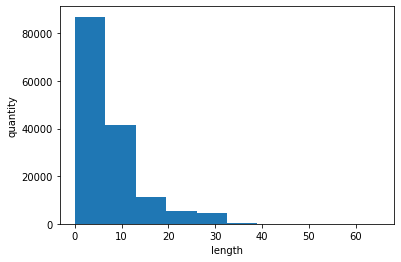

In [242]:
print('리뷰 최대 길이:', max(len(i) for i in train_x))
print('리뷰 평균 길이:', sum((len(i))/len(train_x) for i in train_x))

plt.hist([len(i) for i in train_x])
plt.xlabel('length')
plt.ylabel('quantity')


*   패딩 30개로 결정








In [255]:
max_len = 30
train_x = pad_sequences(train_x, maxlen = max_len)
test_x = pad_sequences(test_x, maxlen = max_len)

In [257]:
train_x[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  294,
        304,  411,    1, 1126,   10,  575,  636,  206], dtype=int32)

## (4) LSTM 사용

In [260]:
# 모형정의
vocab_size = len(train_x)

In [261]:
# 모형 정의
model = tf.keras.Sequential([            #sequential: 층 하나씩 추가
                             tf.keras.layers.Embedding(vocab_size,100),    # embedding: 밀집벡터로 만듦. (vocab의 개수, 출력할 벡터의 차원, input의 최대 길이) . 원핫인코딩(0,1만 존재)과 반대의 개념
                             tf.keras.layers.LSTM(128),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(2, activation='softmax')      # dense: 전결합층 추가. (출력할 뉴런의 개수, 활성함수)
                             ])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
              # 모델을 기계가 이해할 수 있도록 컴파일
              # optimizer: 훈련 과정을 설정하는 옵티마이저를 설정
              # loss: 훈련 과정에서 사용할 손실 함수(loss function)를 설정
              # metrics : 훈련을 모니터링하기 위한 지표를 선택

In [262]:
#모형 학습
history = model.fit(train_x, train_y, epochs=5, batch_size=60, validation_split=0.2)
              # fit: 모델이 데이터에 적합해가는 과정
              # batch_size: 한 번에 학습시킬 데이터 양
              # epochs: 에포크. 총 훈련 횟수를 의미. 5는 5번 훑음을 뜻함
              # validation_split: 훈련 데이터의 20%를 검증 데이터로 사용.

Epoch 1/5
2000/2000 [==============================] - 271s 135ms/step - loss: 0.4230 - accuracy: 0.7963 - val_loss: 0.3853 - val_accuracy: 0.8204
Epoch 2/5
2000/2000 [==============================] - 272s 136ms/step - loss: 0.3209 - accuracy: 0.8560 - val_loss: 0.4045 - val_accuracy: 0.8152
Epoch 3/5
2000/2000 [==============================] - 271s 135ms/step - loss: 0.2586 - accuracy: 0.8841 - val_loss: 0.4238 - val_accuracy: 0.8146
Epoch 4/5
2000/2000 [==============================] - 271s 135ms/step - loss: 0.2088 - accuracy: 0.9077 - val_loss: 0.4897 - val_accuracy: 0.8053
Epoch 5/5
2000/2000 [==============================] - 270s 135ms/step - loss: 0.1702 - accuracy: 0.9249 - val_loss: 0.5978 - val_accuracy: 0.8045


## (3) 검증

In [265]:
# 텍스트 정확도
model.evaluate(test_x, test_y)[1]

1563/1563 [==============================] - 17s 11ms/step - loss: 0.6022 - accuracy: 0.8081


0.8081485033035278

In [290]:
def predict_pos_text(text):
    token=[]
    tokens = postagging_mecab(text) 
    token.append(tokens)
    print(token,'\n')
    train_x = tokenizer.texts_to_sequences(token)
    max_len=30
    train_x = pad_sequences(train_x, maxlen = max_len)
    score = float(model.predict(train_x)[0][1])
    #print('score:', type(score))
    if score>0.5:
        print("[{}]는 {:.2f}% 확률로 긍정 리뷰입니다.\n".format(text, score * 100))
    else:
        print("[{}]는 {:.2f}% 확률로 부정 리뷰입니다.\n".format(text, (1 - score) * 100))

In [291]:
predict_pos_text('아 진짜 개개개개개 재미없네')

[['진짜', '개개', '개개', '재미없']] 

[아 진짜 개개개개개 재미없네]는 99.99% 확률로 부정 리뷰입니다.



In [292]:
predict_pos_text('너무 잘 생겼고, 또 보고 싶어요')

[['너무', '생겼', '어요']] 

[너무 잘 생겼고, 또 보고 싶어요]는 89.50% 확률로 긍정 리뷰입니다.

